# Forecast

## Setup

In [1]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy as sp

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS, Naive

from pathlib import Path
from joblib import Parallel, delayed
from itertools import product
from tqdm import tqdm

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (16, 4)


/home/ec2-user/anaconda3/envs/forecasting/lib/python3.10/site-packages/statsforecast/core.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Prepare data

In [2]:
sales = pd.read_csv("../data/sales_train_evaluation.csv")
sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [3]:
calendar = pd.read_csv("../data/calendar.csv", parse_dates=["date"])
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
sell_prices = pd.read_csv("../data/sell_prices.csv")
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
def prepare_data(sales, calendar, sell_prices, freq=None):
    Path("../data/processed").mkdir(exist_ok=True)

    hierarchy_df = sales.iloc[:, 1:6].copy()
    df = sales.drop(columns=["id", "dept_id", "cat_id", "state_id"])
    df = df.reset_index().rename(columns={"index": "unique_id"})
    df_long = pd.melt(df, id_vars=df.columns[:3], var_name="d", value_name="sales")
    df_long = df_long.merge(calendar[["date", "d", "wm_yr_wk"]], on="d", how="left")
    df_long = df_long.merge(sell_prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df_long["dollar_sales"] = df_long["sales"] * df_long["sell_price"]
    df_long.loc[df_long.sales == 0, "dollar_sales"] = 0
    df_long["d"] = df_long["d"].str[2:].astype("int")
    df = pd.pivot_table(df_long, values=["sales", "dollar_sales"], index=["date"], columns=["unique_id"])

    if freq is not None:
        df = df.resample(freq).sum()

    bts_df = df["sales"].reset_index()
    bts_df.columns = bts_df.columns.astype("str")

    bts_dollar_df = df["dollar_sales"].reset_index()
    bts_dollar_df.columns = bts_dollar_df.columns.astype("str")

    filepath = Path("../data/processed/bts.csv")
    bts_df.to_csv(filepath, index=False)
    print(f"Data written to {filepath}")
    
    filepath = Path("../data/processed/bts_dollar.csv")
    bts_dollar_df.to_csv(filepath, index=False)
    print(f"Data written to {filepath}")

    filepath = Path("../data/processed/hierarchy.csv")
    hierarchy_df.to_csv(filepath, index=False)
    print(f"Data written to {filepath}")
    
    return bts_df, bts_dollar_df, hierarchy_df

In [6]:
bts_df, bts_dollar_df, hierarchy_df = prepare_data(sales, calendar, sell_prices, freq="MS")

Data written to ../data/processed/bts.csv
Data written to ../data/processed/bts_dollar.csv
Data written to ../data/processed/hierarchy.csv


In [7]:
bts_df

unique_id,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,...,29991,29992,29993,29994,29995,29996,29997,29998,29999,30000,30001,30002,30003,30004,30005,30006,30007,30008,30009,30010,30011,30012,30013,30014,30015,30016,30017,30018,30019,30020,30021,30022,30023,30024,30025,30026,30027,30028,30029,30030,30031,30032,30033,30034,30035,30036,30037,30038,30039,30040,30041,30042,30043,30044,30045,30046,30047,30048,30049,30050,30051,30052,30053,30054,30055,30056,30057,30058,30059,30060,30061,30062,30063,30064,30065,30066,30067,30068,30069,30070,30071,30072,30073,30074,30075,30076,30077,30078,30079,30080,30081,30082,30083,30084,30085,30086,30087,30088,30089,30090,30091,30092,30093,30094,30095,30096,30097,30098,30099,30100,30101,30102,30103,30104,30105,30106,30107,30108,30109,30110,30111,30112,30113,30114,30115,30116,30117,30118,30119,30120,30121,30122,30123,30124,30125,30126,30127,30128,30129,30130,30131,30132,30133,30134,30135,30136,30137,30138,30139,30140,30141,30142,30143,30144,30145,30146,30147,30148,30149,30150,30151,30152,30153,30154,30155,30156,30157,30158,30159,30160,30161,30162,30163,30164,30165,30166,30167,30168,30169,30170,30171,30172,30173,30174,30175,30176,30177,30178,30179,30180,30181,30182,30183,30184,30185,30186,30187,30188,30189,30190,30191,30192,30193,30194,30195,30196,30197,30198,30199,30200,30201,30202,30203,30204,30205,30206,30207,30208,30209,30210,30211,30212,30213,30214,30215,30216,30217,30218,30219,30220,30221,30222,30223,30224,30225,30226,30227,30228,30229,30230,30231,30232,30233,30234,30235,30236,30237,30238,30239,30240,30241,30242,30243,30244,30245,30246,30247,30248,30249,30250,30251,30252,30253,30254,30255,30256,30257,30258,30259,30260,30261,30262,30263,30264,30265,30266,30267,30268,30269,30270,30271,30272,30273,30274,30275,30276,30277,30278,30279,30280,30281,30282,30283,30284,30285,30286,30287,30288,30289,30290,30291,30292,30293,30294,30295,30296,30297,30298,30299,30300,30301,30302,30303,30304,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30320,30321,30322,30323,30324,30325,30326,30327,30328,30329,30330,30331,30332,30333,30334,30335,30336,30337,30338,30339,30340

In [8]:
bts_dollar_df

unique_id       date       0      1      2       3       4      5       6  \
0         2011-01-01    0.00   0.00   0.00    0.00    0.00   0.00    0.00   
1         2011-02-01    0.00   0.00   0.00    0.00    0.00   0.00    0.00   
2         2011-03-01    0.00   0.00   0.00   73.78    0.00   0.00    0.00   
3         2011-04-01    0.00   0.00   0.00   99.82    0.00   0.00    0.00   
4         2011-05-01    0.00   0.00   0.00  147.56   92.38   0.00    0.00   
..               ...     ...    ...    ...     ...     ...    ...     ...   
60        2016-01-01  198.24  15.88  17.82  296.96   63.36  24.96  110.32   
61        2016-02-01  239.54  19.85  26.73  278.40   95.04  27.84   63.04   
62        2016-03-01  239.54  39.70  44.55  245.92  112.32  33.60  110.32   
63        2016-04-01  258.58   7.94  59.40  273.76  103.68  15.36   70.92   
64        2016-05-01  234.64  23.82  50.49  190.24   92.16  25.92   55.16   

unique_id       7       8      9     10      11     12     13      14      15  \
0           12.42   14.04   3.17   0.00   11.96   0.00   0.00    2.80    6.30   
1           44.88   93.60  15.85   0.00  107.64   0.00   0.00  100.30  126.58   
2            7.56   99.99   0.00   0.00   86.33   0.00   0.00  112.32  133.92   
3           67.56  107.97   0.00   0.00  119.13   0.00   0.00   93.32  158.12   
4           62.00  107.97  17.82   0.00  106.59   0.00   0.00  121.72  225.76   
..            ...     ...    ...    ...     ...    ...    ...     ...     ...   
60         198.72    0.00  56.43  17.40   26.08  17.73  97.44   62.30  117.60   
61         172.80    0.00  56.43  13.92   32.60  21.67  48.72   54.60  100.80   
62          76.80   21.24  38.61  13.92   32.60  19.70  69.60   75.60  106.40   
63         131.04   53.10  56.43   3.48   32.60  29.55  51.04   57.40  140.70   
64         117.12   17.70  35.64   3.48   39.12  21.67  42.92   40.60   70.70   

unique_id     16     17      18      19      20      21      22     23     24  \
0           0.00   0.00    0.00    0.00    0.00   27.44   10.32   0.00   0.00   
1           0.00   0.00    0.00   85.36    0.00  157.78  106.64   0.00   0.00   
2           0.00   0.00    0.00  131.76  117.70  179.92  161.68   0.00   0.00   
3           0.00   0.00    0.00  120.78  706.60  153.56  264.88   0.00   0.00   
4           0.00   0.00    0.00  219.60  742.14  139.60  178.88   0.00   0.00   
..           ...    ...     ...     ...     ...     ...     ...    ...    ...   
60         53.46  35.64  151.68  202.88  332.64   57.44   45.81  25.68  67.66   
61         75.24   0.00   36.96   76.08  320.76   57.44   47.52  77.04  83.58   
62         53.46   0.00   96.96  101.44  201.96  100.52   83.16  17.12  59.70   
63         91.08   0.00  142.08   63.40  285.12   64.62  133.65  25.68  83.58   
64         69.30  35.64   69.60   25.36  249.48   28.72   89.10  42.80  47.76   

unique_id      25      26      27      28     29      30      31      32  \
0            0.00    0.00    0.00   37.20    0.0    0.00    6.58    0.00   
1            0.00    0.00   40.02  290.16    0.0   32.55  151.81    0.00   
2            0.00    0.00  265.24  290.16    0.0   54.90  134.42    0.00   
3            0.00    0.00  328.06  245.52    0.0   54.90  114.22    0.00   
4            0.00    0.00  265.24  163.68    0.0   32.94  153.36    0.00   
..            ...     ...     ...     ...    ...     ...     ...     ...   
60           0.00  479.52  159.60  655.54  170.8   76.86   84.36  131.32   
61          66.91  299.70  151.62  457.98  160.3  120.78   74.10  134.88   
62         107.82  259.74  199.50  466.96  128.8  153.72   64.41  252.90   
63         143.76  199.80  159.60  431.04  116.2   76.86   58.71   84.30   
64          71.88  279.72  159.60  287.36   70.0   21.96   71.82  101.16   

unique_id      33     34     35      36     37     38      39     40      41  \
0            0.00   0.00   2.88    0.00   6.34   0.00    0.00   0.00    0.00   
1           27.96   0.00  30.72    0.00  50.72   0.00   

In [9]:
hierarchy_df

,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA
...,...,...,...,...,...
30485,FOODS_3_823,FOODS_3,FOODS,WI_3,WI
30486,FOODS_3_824,FOODS_3,FOODS,WI_3,WI
30487,FOODS_3_825,FOODS_3,FOODS,WI_3,WI
30488,FOODS_3_826,FOODS_3,FOODS,WI_3,WI


## Build S matrix

In [10]:
#hierarchy_df = pd.read_csv("../data/processed/hierarchy.csv")

In [11]:
agg_levels = (
    tuple(["TOTAL"]),
    tuple(['state_id']),
    tuple(['store_id']),
    tuple(['cat_id']),
    tuple(['dept_id']),
    tuple(['state_id', 'cat_id']),
    tuple(['state_id', 'dept_id']),
    tuple(['store_id', 'cat_id']),
    tuple(['store_id', 'dept_id']),
    tuple(['item_id']),
    tuple(['item_id', 'state_id']),
    tuple(['item_id', 'store_id']),
)

In [12]:
def generate_Smatrix(hierarchy_df, agg_levels, sparse=True):
    arr = np.array
    eye = np.eye
    stack = np.row_stack
    
    if sparse:
        arr = sp.sparse.csr_array
        eye = sp.sparse.eye
        stack = sp.sparse.vstack

    def build_row(hierarchy_df, level, comb):
        row = (hierarchy_df.loc[:, level] == comb).apply(lambda x: all(x), axis=1).astype("int16")
        return row
    
    top_row = np.ones(len(hierarchy_df))
    S_rows = [top_row]

    for level in agg_levels[1:-1]:
        print(level)
        combinations = hierarchy_df.loc[:, level].drop_duplicates().to_numpy()
        rows = Parallel(n_jobs=8)(
            delayed(build_row)(hierarchy_df, level, comb) for comb in combinations
        )
        S_rows.extend(rows)

    S_top = arr(S_rows)
    S_bottom = eye(len(hierarchy_df))
    S_arr = stack([S_top, S_bottom])
    
    filepath = Path("../data/processed/S_arr.npz")
    sp.sparse.save_npz(filepath, S_arr)
    print(f"Data written to {filepath}")
    return S_arr

In [13]:
S_arr = generate_Smatrix(hierarchy_df, agg_levels)

('state_id',)
('store_id',)
('cat_id',)
('dept_id',)
('state_id', 'cat_id')
('state_id', 'dept_id')
('store_id', 'cat_id')
('store_id', 'dept_id')
('item_id',)
('item_id', 'state_id')
Data written to ../data/processed/S_arr.npz


In [14]:
S_arr.shape

(42840, 30490)

## Generate all the timeseries from the hierarchy

In [ ]:
#bts_df = pd.read_csv("../data/processed/bts.csv", parse_dates=["date"])
#bts_dollar_df = pd.read_csv("../data/processed/bts_dollar.csv", parse_dates=["date"])
#S_arr = sp.sparse.load_npz("../data/processed/S_arr.npz")

In [15]:
def generate_yts(S_arr, bts_df):
    bts_arr = bts_df.set_index("date").to_numpy()
    yts_arr = S_arr @ bts_arr.T
    yts_df = pd.DataFrame(yts_arr.T)
    yts_df.insert(0, "date", bts_df["date"])
    return yts_df

yts_df = generate_yts(S_arr, bts_df)
yts_dollar_df = generate_yts(S_arr, bts_dollar_df)

filepath = Path("../data/processed/yts.csv")
yts_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

filepath = Path("../data/processed/yts_dollar.csv")
yts_dollar_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

Data written to ../data/processed/yts.csv
Data written to ../data/processed/yts_dollar.csv


In [16]:
yts_df

date          0         1         2         3         4         5  \
0  2011-01-01    88163.0   38108.0   25846.0   24209.0   11308.0    8661.0   
1  2011-02-01   726375.0  318101.0  212015.0  196259.0   89434.0   67686.0   
2  2011-03-01   763567.0  339678.0  225162.0  198727.0   93468.0   73964.0   
3  2011-04-01   737713.0  331004.0  220681.0  186028.0   91553.0   72803.0   
4  2011-05-01   719562.0  321566.0  221620.0  176376.0   87988.0   68305.0   
..        ...        ...       ...       ...       ...       ...       ...   
60 2016-01-01  1215286.0  525392.0  321790.0  368104.0  131598.0  128709.0   
61 2016-02-01  1212927.0  505704.0  328110.0  379113.0  126655.0  121210.0   
62 2016-03-01  1275746.0  538930.0  343674.0  393142.0  136557.0  126302.0   
63 2016-04-01  1283470.0  544960.0  337226.0  401284.0  138826.0  135984.0   
64 2016-05-01   994982.0  419627.0  264718.0  310637.0  108053.0  107457.0   

           6        7         8         9        10        11        12  \
0    13351.0   4788.0    7065.0   10520.0    8261.0    6460.0    6196.0   
1   119792.0  41189.0   62534.0   84900.0   64581.0   46592.0   51708.0   
2   127344.0  44902.0   66890.0   89902.0   68370.0   49747.0   51113.0   
3   122428.0  44220.0   66435.0   87683.0   66563.0   46898.0   47651.0   
4   120711.0  44562.0   67920.0   86128.0   67572.0   45269.0   45487.0   
..       ...      ...       ...       ...       ...       ...       ...   
60  189217.0  75868.0   93112.0  116650.0  112028.0  113934.0  140948.0   
61  185822.0  72017.0   93504.0  121410.0  113196.0  109622.0  154084.0   
62  196350.0  79721.0  100805.0  125617.0  117252.0  114348.0  159236.0   
63  189806.0  80344.0  101135.0  119588.0  116503.0  118201.0  162908.0   
64  140870.0  63247.0   78215.0   92645.0   93858.0   90155.0  126299.0   

          13        14        15        16        17       18        19  \
0    11553.0    9803.0   15250.0   63110.0    9279.0    524.0   10790.0   
1    97959.0   77362.0  128763.0  520250.0   73316.0   4046.0   90773.0   
2    97867.0   83691.0  144962.0  534914.0   78140.0   5551.0  105264.0   
3    91479.0   86199.0  141946.0  509568.0   80455.0   5744.0  103027.0   
4    85620.0   87413.0  140396.0  491753.0   81096.0   6317.0   99905.0   
..       ...       ...       ...       ...       ...      ...       ...   
60  113222.0  117553.0  290293.0  807440.0  107390.0  10163.0  236184.0   
61  115407.0  112939.0  295249.0  804739.0  102243.0  10696.0  238352.0   
62  119558.0  116241.0  304051.0  855454.0  105133.0  11108.0  243840.0   
63  120175.0  121217.0  304291.0  857962.0  109051.0  12166.0  241618.0   
64   94183.0   91658.0  226486.0  676838.0   81183.0  10475.0  177181.0   

         20       21        22        23       24        25        26  \
0    4460.0   6216.0   11477.0   45417.0   4835.0    6366.0   26907.0   
1   37990.0  54155.0   97919.0  368176.0  39825.0   55203.0  223073.0   
2   39698.0  53527.0  101792.0  379595.0  43502.0   63804.0  232372.0   
3   38919.0  50678.0   95555.0  363335.0  43569.0   64259.0  223176.0   
4   40491.0  47358.0   95489.0  348906.0  43878.0   63983.0  213705.0   
..      ...      ...       ...       ...      ...       ...       ...   
60  54109.0  98250.0  175997.0  533193.0  59399.0  126643.0  339350.0   
61  56897.0  89691.0  162777.0  552271.0  54706.0  122469.0  328529.0   
62  60211.0  95893.0  172242.0  587319.0  56845.0  130715.0  351370.0   
63  62673.0  92282.0  175215.0  590465.0  57590.0  134780.0  352590.0   
64  49305.0  82460.0  136630.0  457748.0  44316.0  101318.0  273993.0   

         27       28        29       30       31        32       33      34  \
0    2275.0   4564.0   19007.0   2693.0   4320.0   17196.0   4663.0   172.0   
1   17833.0  39033.0  155149.0  19704.0  34527.0  142028.0  38371.0  1454.0   
2   18499.0  41902.0  164761.0  21690.0  39256.0  137781.0  41315.0  2187.0   
3   19947.0  41587.0  159147.0  22683.0  36100.0  127245.0  41395.0  2174.0  

In [17]:
yts_dollar_df

date           0           1           2           3          4  \
0  2011-01-01   218328.09    96607.29    64481.96    57238.84   27921.60   
1  2011-02-01  1925877.70   858141.49   566704.60   501031.61  233687.91   
2  2011-03-01  2052900.47   934485.77   603579.99   514834.71  249606.68   
3  2011-04-01  2027413.92   938121.11   602348.37   486944.44  258612.43   
4  2011-05-01  2002988.04   926659.08   606963.34   469365.62  251748.36   
..        ...         ...         ...         ...         ...        ...   
60 2016-01-01  3817490.54  1685250.81  1048777.13  1083462.60  425064.88   
61 2016-02-01  3821898.04  1625600.26  1080712.60  1115585.18  405169.47   
62 2016-03-01  3976337.84  1733281.36  1110376.23  1132680.25  435510.84   
63 2016-04-01  4067823.39  1797201.39  1099718.49  1170903.51  451750.43   
64 2016-05-01  3151716.20  1386233.43   866166.31   899316.46  350082.64   

            5          6          7          8          9         10  \
0    22839.56   32965.15   12880.98   17749.25   26371.48   20361.23   
1   195198.60  317303.99  111950.99  165410.83  229946.55  171347.22   
2   214501.18  346333.56  124044.35  176683.97  245233.84  181662.18   
3   212021.00  340933.48  126554.20  176798.97  245659.10  179890.30   
4   206895.86  336697.87  131316.99  178401.92  243166.38  185395.04   
..        ...        ...        ...        ...        ...        ...   
60  424520.16  592548.13  243117.64  292041.98  375086.36  381648.79   
61  396634.60  589958.89  233837.30  296143.43  394796.63  389772.54   
62  410746.72  628615.85  258407.95  315331.60  400905.22  394139.41   
63  449155.36  629891.22  266404.38  315482.21  389175.77  395060.51   
64  355414.83  473688.13  207047.83  248845.48  300173.78  317147.05   

           11         12         13         14          15          16  \
0    15740.61   14709.90   26788.33   25061.82    63814.96   129451.31   
1   125589.24  133849.60  241592.77  211030.97   552493.10  1162353.63   
2   134904.04  133895.48  246035.19  233051.73   607745.62  1212103.12   
3   130208.60  123607.85  233127.99  250924.28   609446.74  1167042.90   
4   128402.48  117263.83  223699.31  259676.41   598220.97  1145090.66   
..        ...        ...        ...        ...         ...         ...   
60  344615.72  420603.46  318243.42  515426.35  1131872.08  2170192.11   
61  332191.25  458428.09  324965.84  505127.06  1173626.67  2143144.31   
62  339373.85  461179.48  332126.92  516780.48  1201569.46  2257987.90   
63  358201.44  472018.75  340683.32  523247.88  1234493.14  2310082.37   
64  271798.67  361812.12  265705.67  398775.69   929876.14  1823064.37   

           17        18         19         20         21         22  \
0    23718.85   1342.97   40924.43   22890.53   15413.91   34798.78   
1   201442.69   9588.28  358717.75  193775.35  146154.43  305266.97   
2   218890.29  14161.44  406512.78  201232.84  137385.22  308326.94   
3   236122.75  14801.53  412545.06  196901.68  132254.60  272889.26   
4   243585.53  16090.88  394400.22  203820.75  121463.47  269246.86   
..        ...       ...        ...        ...        ...        ...   
60  493664.99  21761.36  874730.82  257141.26  267516.46  630881.74   
61  482714.49  22412.57  900480.89  273145.78  254345.67  599410.36   
62  493113.69  23666.79  911522.40  290047.06  264664.56  612629.99   
63  497855.90  25391.98  935260.88  299232.26  263443.83  617401.27   
64  377241.95  21533.74  694852.76  235023.38  227402.93  475165.61   

            23         24         25         26         27         28  \
0     79238.62   10711.10   27581.79   58314.40    7529.58   17866.28   
1    710932.23   97368.76  250162.46  510610.27   56818.03  156046.49   
2    766390.96  109869.51  284058.22  540558.04   61082.42  166587.36   
3    761899.04  117021.07  295246.10  525853.94   68456.65  166757.40   
4    754380.33  120215.81  288950.89  517492.38   72988.33  166918.76   
..         ...        ...        ...        ...    

## Create panel data

In [18]:
#yts_df = pd.read_csv("../data/processed/yts.csv", parse_dates=["date"])

In [20]:
def generate_panel_yts(yts_df):
    y_list = []
    for col in tqdm(yts_df.columns[1:]):
        y = yts_df[["date", col]]
        y = y.rename(columns={"date": "ds", col: "y"})
        y.insert(0, "unique_id", col)
        y_list.append(y)
    yts_panel = pd.concat(y_list)

    filepath = Path("../data/processed/yts_panel.csv")
    yts_panel.to_csv(filepath, index=False)
    print(f"Data written to {filepath}")

    return yts_panel

In [21]:
yts_panel = generate_panel_yts(yts_df)

100%|██████████| 42840/42840 [00:27<00:00, 1545.29it/s]


Data written to ../data/processed/yts_panel.csv


## Forecast

In [22]:
#yts_panel = pd.read_csv("../data/processed/yts_panel.csv", parse_dates=["ds"])

In [23]:
# We burn the first and last month because they had less data during resampling
yts_panel = yts_panel[(yts_panel.ds > "2011-01-01") & (yts_panel.ds < "2016-05-01")]

In [24]:
# Smaller dataset to test the pipeline
yts_panel = yts_panel[yts_panel.unique_id < 100]

In [25]:
yts_train = yts_panel[(yts_panel.ds <= "2015-04-01")]
yts_test = yts_panel[(yts_panel.ds > "2015-04-01")]

<AxesSubplot: xlabel='ds'>

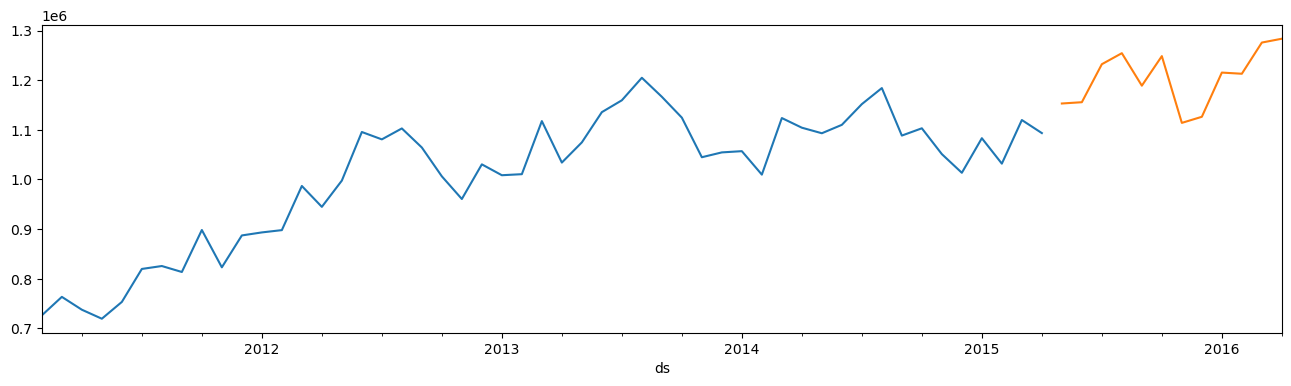

In [26]:
i = 0
yts_train.loc[yts_train.unique_id == i].set_index("ds")["y"].plot()
yts_test.loc[yts_test.unique_id == i].set_index("ds")["y"].plot()

In [27]:
models = [
    ETS(season_length=12, model='ZZA'),
    AutoARIMA(season_length=12, max_d=1, max_D=1)
]

model = StatsForecast(
    df=yts_train, 
    models=models,
    freq='MS',
    fallback_model=Naive(),
    n_jobs=-1,
)

fcst_df = model.forecast(12, level=[80, 95], fitted=True).reset_index()
fitted_df = model.forecast_fitted_values().reset_index()

Path("../fcst").mkdir(exist_ok=True)

filepath = Path("../fcst/fcst.csv")
fcst_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

filepath = Path("../fcst/fitted.csv")
fitted_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

Data written to ../fcst/fcst.csv
Data written to ../fcst/fitted.csv


## Plot results

In [30]:
#fcst_df = pd.read_csv("../fcst/fcst.csv", parse_dates=["ds"])
#fitted_df = pd.read_csv("../fcst/fitted.csv", parse_dates=["ds"])

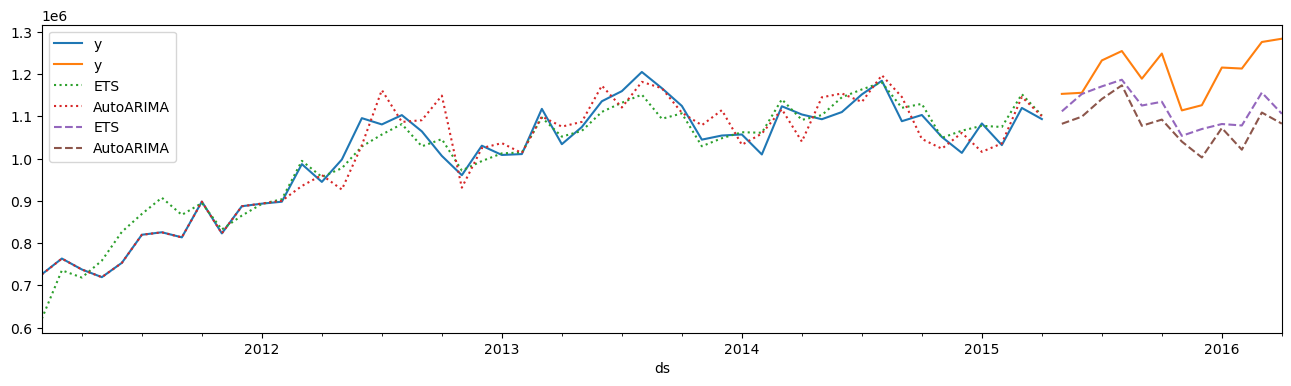

In [31]:
i = 0

yts_train.loc[yts_train.unique_id == i].set_index("ds")["y"].plot()
yts_test.loc[yts_test.unique_id == i].set_index("ds")["y"].plot()

fitted_df.loc[fitted_df.unique_id == i].set_index("ds")["ETS"].plot(style=":")
fitted_df.loc[fitted_df.unique_id == i].set_index("ds")["AutoARIMA"].plot(style=":")

fcst_df.loc[fcst_df.unique_id == i].set_index("ds")["ETS"].plot(style="--")
fcst_df.loc[fcst_df.unique_id == i].set_index("ds")["AutoARIMA"].plot(style="--")

plt.legend()